
# Simplified LLM Memory Requirements — Transformer Decoder (LLaMA‑2 7B Example)

*Generated on 2025-10-28 19:21:59*

This tutorial estimates **GPU memory requirements** for a **decoder‑only Transformer** such as **LLaMA‑2 7B**,  
using simple **rules of thumb** for both **training** and **inference**.

We assume:
- FP16/BF16 precision (2 bytes / float)
- AdamW optimizer
- No activation checkpointing
- Context length = 4096 tokens  
- Batch size = 4


In [ ]:

# ==============================
# Define variables (edit these)
# ==============================

# Model architecture
num_params   = 6.74e9   # total parameters
num_layers   = 32       # number of transformer layers
hidden_size  = 4096     # model hidden dimension
num_heads    = 32       # attention heads
head_dim     = hidden_size // num_heads  # dimension per head (128)

# Data / batch
batch_size   = 4        # batch size (examples)
seq_len      = 4096     # context length (tokens)

# Precision and constants
bytes_per_float = 2     # FP16/BF16 precision
adam_overhead   = 12    # AdamW optimizer overhead (m, v, master weights)
activation_scale = 7.0  # rule of thumb for activations per token per layer
kv_bytes_per_elem = 2   # FP16 KV cache element size

# Conversion constant
BYTES_PER_GIB = 1.073741824e9


In [5]:

# ==============================
# Training memory estimate
# ==============================

def estimate_training_memory(params, layers, hidden, batch, seq,
                             bytes_per_float=2, adam_overhead=12, activation_scale=7.0):
    """Estimate training memory (GiB)."""
    # Model weights + gradients + optimizer
    param_bytes = params * (bytes_per_float + bytes_per_float + adam_overhead)
    # Activations
    act_bytes = batch * seq * layers * hidden * bytes_per_float * activation_scale
    total_bytes = param_bytes + act_bytes
    return total_bytes / BYTES_PER_GIB, param_bytes / BYTES_PER_GIB, act_bytes / BYTES_PER_GIB

train_total, train_params, train_acts = estimate_training_memory(
    num_params, num_layers, hidden_size, batch_size, seq_len,
    bytes_per_float, adam_overhead, activation_scale)

print(f"Training total memory: {train_total:.1f} GiB")
print(f"  Parameters + optimizer: {train_params:.1f} GiB")
print(f"  Activations: {train_acts:.1f} GiB")


Training total memory: 128.4 GiB
  Parameters + optimizer: 100.4 GiB
  Activations: 28.0 GiB


In [ ]:

# ==============================
# Inference memory estimate (prefill)
# ==============================

#only used during inference
def kv_cache_bytes(layers, batch, seq, heads, head_dim, bytes_per_elem=2):
    """Approximate KV cache size in bytes."""
    return layers * batch * heads * seq * head_dim * bytes_per_elem * 2  # K and V

def estimate_inference_memory(params, layers, batch, seq, heads, head_dim,
                              bytes_per_float=2, kv_bytes_per_elem=2):
    """Estimate inference memory (GiB)."""
    weights = params * bytes_per_float
    kv_cache = kv_cache_bytes(layers, batch, seq, heads, head_dim, kv_bytes_per_elem)
    total = weights + kv_cache
    return total / BYTES_PER_GIB, weights / BYTES_PER_GIB, kv_cache / BYTES_PER_GIB

infer_total, infer_weights, infer_kv = estimate_inference_memory(
    num_params, num_layers, batch_size, seq_len, num_heads, head_dim,
    bytes_per_float, kv_bytes_per_elem)

print(f"Inference total (prefill): {infer_total:.1f} GiB")
print(f"  Weights: {infer_weights:.1f} GiB")
print(f"  KV cache: {infer_kv:.1f} GiB")


Inference total (prefill): 20.6 GiB
  Weights: 12.6 GiB
  KV cache: 8.0 GiB


In [10]:
kv_cache_bytes(40, 1, 2048, 1, 4096, bytes_per_elem=4)

2684354560

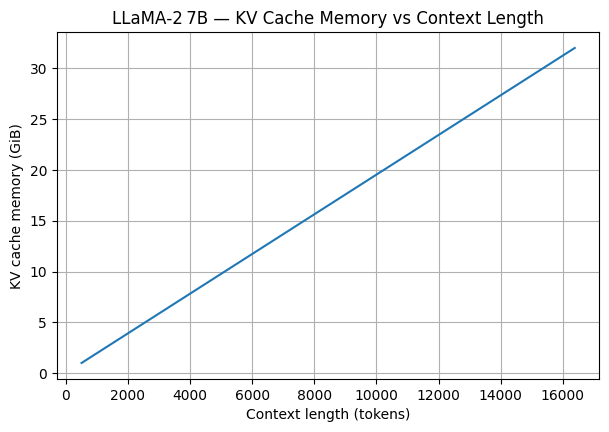

In [7]:

# ==============================
# KV cache scaling with context length
# ==============================
import numpy as np
import matplotlib.pyplot as plt

seq_values = np.array([512, 1024, 2048, 4096, 8192, 16384])
kv_gib = [
    kv_cache_bytes(num_layers, batch_size, s, num_heads, head_dim, kv_bytes_per_elem) / BYTES_PER_GIB
    for s in seq_values
]

plt.figure(figsize=(7, 4.5))
plt.plot(seq_values, kv_gib)
plt.xlabel("Context length (tokens)")
plt.ylabel("KV cache memory (GiB)")
plt.title("LLaMA‑2 7B — KV Cache Memory vs Context Length")
plt.grid(True)
plt.show()



## Simple Rules of Thumb

- **Training memory ≈ 16 bytes / parameter + activation cost.**  
  Activations scale as `batch × seq × layers × hidden × 2 bytes × ~7`.

- **Inference memory ≈ model weights + KV cache.**  
  KV cache scales *linearly* with sequence length, batch size, and layers.

- **For LLaMA‑2 7B (FP16):**
  - Training ≈ 30 – 35 GiB / GPU (before activation sharding)
  - Inference (batch 4, 4 k context) ≈ 25 GiB
  - Doubling context ≈ doubles inference memory
  - Quantizing weights (INT8 / 4‑bit) reduces weight term by ½ – ¼
  - GQA reduces KV cache linearly with fewer KV heads
